# imports

In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization

In [0]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as mn
from sklearn.metrics import r2_score,mean_squared_error
import plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as mn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error

import keras
from keras import Sequential
from keras.layers import SimpleRNN
from keras import models
from keras import layers

from copy import copy

Using TensorFlow backend.


In [0]:
%%time
PRss_df = pd.read_csv("drive/My Drive/para_comb_20p_sample.csv",header=None,engine='python')
print(PRss_df.shape)
print(PRss_df.size)
names = ['Cm','gL','gNa','EL','eNa','EK','gc','gkdr','gAHP','gC','gCa','ECa','p']

(100000, 13)
1300000
CPU times: user 1.84 s, sys: 124 ms, total: 1.97 s
Wall time: 2.27 s


In [0]:
PRag_df = pd.read_csv("drive/My Drive/PR_ag.csv",index_col=0)

In [0]:
PRn_ap_df = PRag_df['n_ap']


In [0]:
PRag_df = PRag_df[['first_ap_time','first_ap_amp','first_ap_width']]

In [0]:
ag_indexes = ~pd.isna(PRag_df).any(axis=1)

In [0]:
PRss_ag_df = PRss_df[ag_indexes]
PRag_df = PRag_df[ag_indexes]
print(PRss_ag_df.shape)
print(PRag_df.shape)

(81250, 13)
(81250, 3)


In [0]:
PRss_ag = PRss_ag_df.values
PRag = PRag_df.values

In [0]:
PRss_ag_df.columns = names

# Correlation

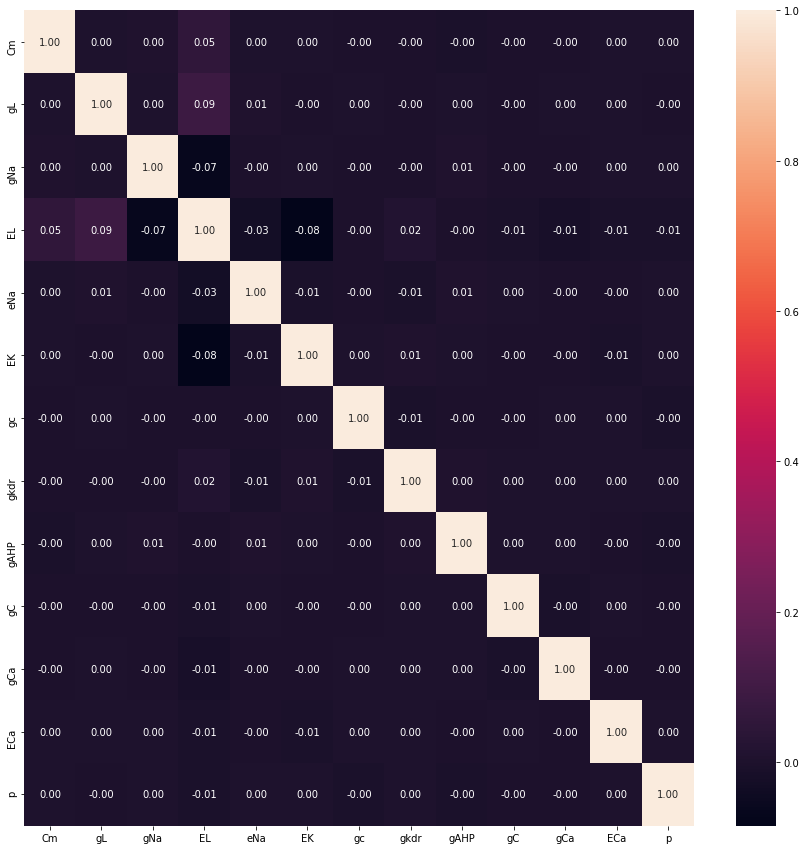

In [0]:
import seaborn as sns
plt.figure(figsize=(15,15))
sns.heatmap(PRss_ag_df.corr(), annot=True, fmt=".2f")
plt.savefig("drive/My Drive/Figures/Appendix/Correlation_org_parameters")

# Standardize and scale

In [0]:
X_Train, X_test, y_Train, y_test = train_test_split(PRss_ag,PRag,test_size=0.3,random_state=111)

scx = StandardScaler()
scy = StandardScaler()


X_Train = scx.fit_transform(X_Train)
y_Train = scy.fit_transform(y_Train)

X_test = scx.transform(X_test)
y_test = scy.transform(y_test)

X_train, X_val, y_train, y_val = train_test_split(X_Train,y_Train,test_size=0.2,random_state=1234)

# Models 

## Models 1

In [0]:
def r_square(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
  
  

In [0]:
model1 = models.Sequential()
model1.add(layers.Dense(20, activation='relu', input_shape=(X_train.shape[1],)))
model1.add(layers.Dense(20, activation='relu'))
model1.add(layers.Dense(y_train.shape[1]))
model1.compile(optimizer='adam', loss='mse', metrics=[r_square])

In [0]:
%%time
history1 = model1.fit(X_Train, y_Train,
                  epochs=1000,
                  batch_size=512,
                  verbose=0,
                  validation_data=(X_val, y_val))

CPU times: user 7min 29s, sys: 39.8 s, total: 8min 9s
Wall time: 5min 48s


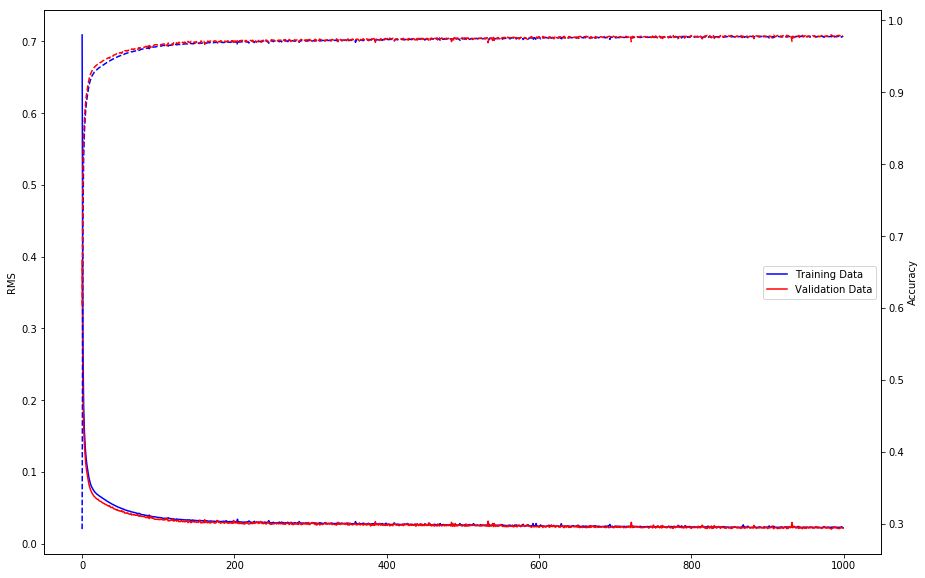

In [0]:
plt.figure(figsize=(15,10))
ax = plt.gca()
ax.plot(history1.history['loss'],label='Training Data',c='blue')
ax.plot(history1.history['val_loss'],label='Validation Data',c='red')
plt.ylabel('RMS')
plt.legend(loc='center right')

ax2 = ax.twinx()
ax2.plot(history1.history['r_square'],'--',c='blue')
ax2.plot(history1.history['val_r_square'],'--',c='red')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.savefig("drive/My Drive/Figures/R2plots/PRag_training")

In [0]:
ypred1 = model1.predict(X_test)
print([r2_score(y_test[:,i],ypred1[:,i]) for i in range(3)])

[0.997961412048378, 0.9987594113050097, 0.9237364746564974]


In [0]:
df.index = ['Time of fist AP','Amplitude of first AP','Width of first AP']

# test model

In [0]:
X_Train, X_test, y_Train, y_test = train_test_split(PRss_ag,PRag,test_size=0.3,random_state=111)

scx = StandardScaler()
scy = StandardScaler()


X_Train = scx.fit_transform(X_Train)
y_Train = scy.fit_transform(y_Train)

X_test = scx.transform(X_test)
y_test = scy.transform(y_test)

In [0]:
model2 = models.Sequential()
model2.add(layers.Dense(20, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(layers.Dense(20, activation='relu'))
model2.add(layers.Dense(y_train.shape[1]))
model2.compile(optimizer='adam', loss='mse', metrics=[r_square])

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model2, to_file="drive/My Drive/Figures/models/PR_ag_arch.png", show_shapes=True, show_layer_names=True)

In [0]:
%%time
history2 = model2.fit(X_Train, y_Train,
                  epochs=600,
                  batch_size=512,
                  verbose=0,
                  validation_data=(X_val, y_val))

CPU times: user 4min 29s, sys: 23.8 s, total: 4min 53s
Wall time: 3min 28s


In [0]:
ypred2 = model2.predict(X_test)
print([r2_score(y_test[:,i],ypred2[:,i]) for i in range(3)])

[0.9980974427289012, 0.9982603559525991, 0.9250692186088547]


# Permuted feature importance

In [0]:
target = PRag_df.columns

In [0]:
from copy import copy

def Permuted_feature_impotance(_X,y,model,seeds=[234]):
  
  base_yhat = model.predict(_X)
  base_line = np.array(
      [mean_squared_error(y[:,c],base_yhat[:,c])
       for c in range(base_yhat.shape[1])])
  
  PFI = np.zeros((len(seeds),_X.shape[1],y.shape[1]))
  
  for i,seed in enumerate(seeds):
    
    np.random.RandomState(seed) # Sets the random state for numpy
    for j in range(X_test.shape[1]):
      
      X = copy(_X)
      X[:,j] = np.random.permutation(X[:,j])

      perm_yhat = model.predict(X)
      
      perm_error = np.array(
          [mean_squared_error(y[:,c],perm_yhat[:,c])
           for c in range(perm_yhat.shape[1])])
      
      



      FI_perm = np.array([mean_squared_error(y[:,c],perm_yhat[:,c]) for c in range(perm_yhat.shape[1])])
      PFI[i,j,:] = FI_perm - base_line
  
  return PFI


In [0]:
%%time
seeds = [123*i for i in range(1,4)]
PFI = Permuted_feature_impotance(X_test,y_test,model1,seeds)

CPU times: user 7min 31s, sys: 3min 21s, total: 10min 52s
Wall time: 14min 49s


In [0]:
m2 = np.mean(PFI2,axis=0)

Text(0.5, 1.0, 'first_ap_time')

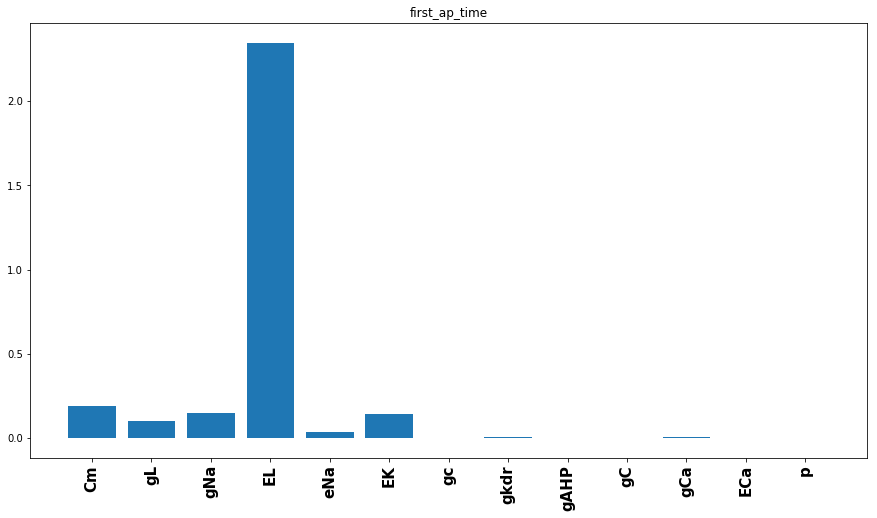

In [0]:
plt.figure(figsize=(15,8))
plt.bar(names,m[:,0])
plt.xticks(rotation='vertical');
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.title(target[0])

Text(0.5, 1.0, 'first_ap_amp')

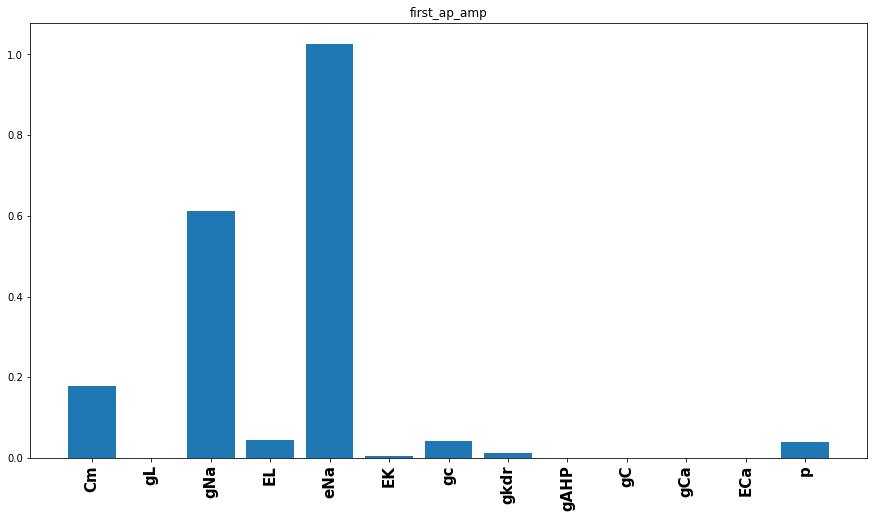

In [0]:
plt.figure(figsize=(15,8))
plt.bar(names,m[:,1])
plt.xticks(rotation='vertical');
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.title(target[1])

Text(0.5, 1.0, 'first_ap_width')

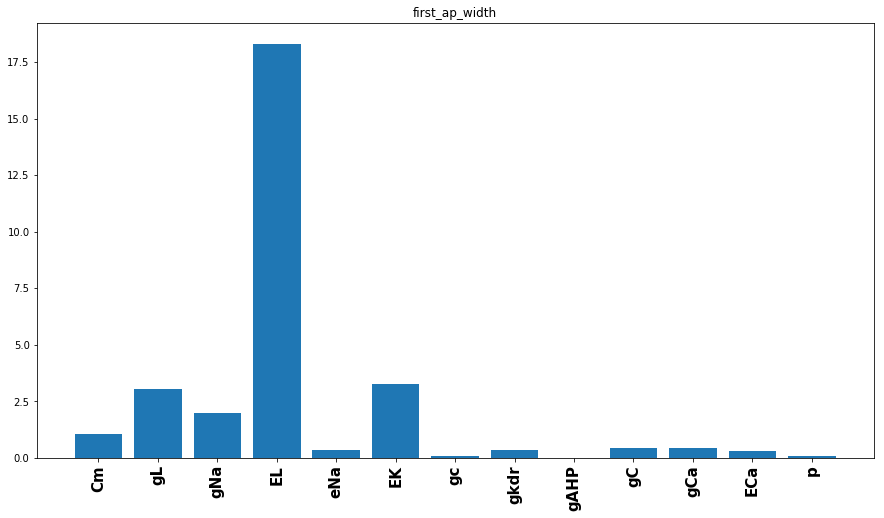

In [0]:
plt.figure(figsize=(15,8))
plt.bar(names,m[:,2])
plt.xticks(rotation='vertical');
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.title(target[2])

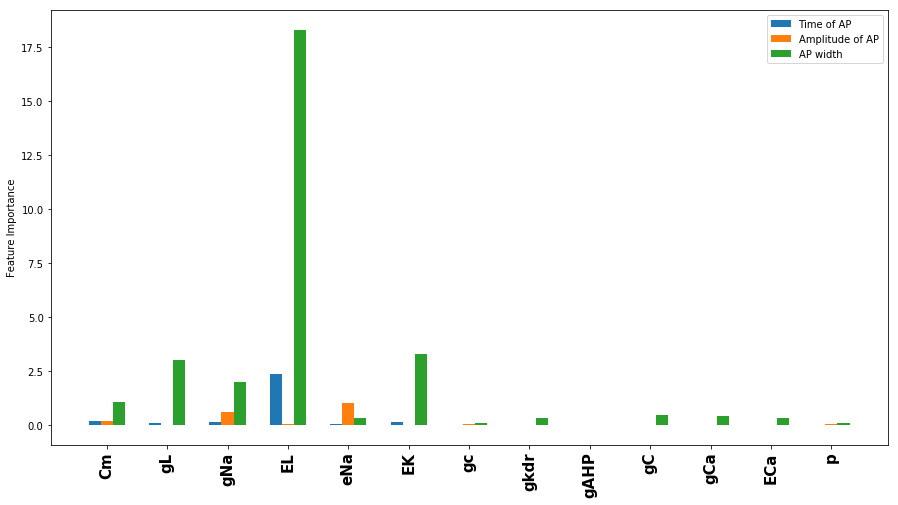

In [0]:
plt.figure(figsize=(15,8))
xa = np.array([i for i in range(len(names))])
plt.bar(xa-0.2,m[:,0],width=0.2)
plt.bar(xa,m[:,1],width=0.2)
plt.bar(xa+0.2,m[:,2],width=0.2)
plt.legend(['Time of AP','Amplitude of AP','AP width'])

plt.xticks(xa,names,fontsize=15,fontweight='bold')
plt.xticks(rotation='vertical');
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.ylabel('Feature Importance')
plt.savefig("drive/My Drive/Figures/R2plots/PRperm_ag")

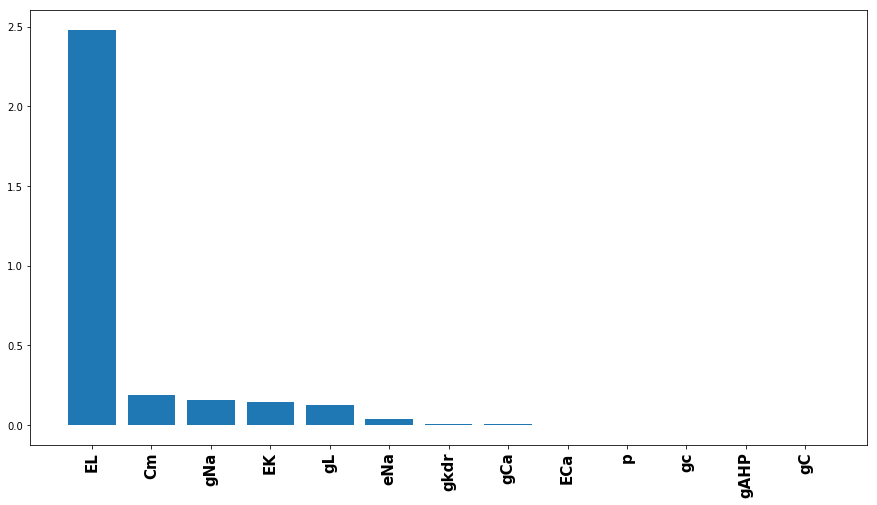

In [0]:
plt.figure(figsize=(15,8))
foonames = [n for _,n in sorted(zip(m[:,0],names))]
foom = sorted(m[:,0])
foonames.reverse()
foom.reverse()
plt.bar(foonames,foom)
plt.xticks(rotation='vertical');
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.savefig("drive/My Drive/Figures/R2plots/First_ap_time_importance")

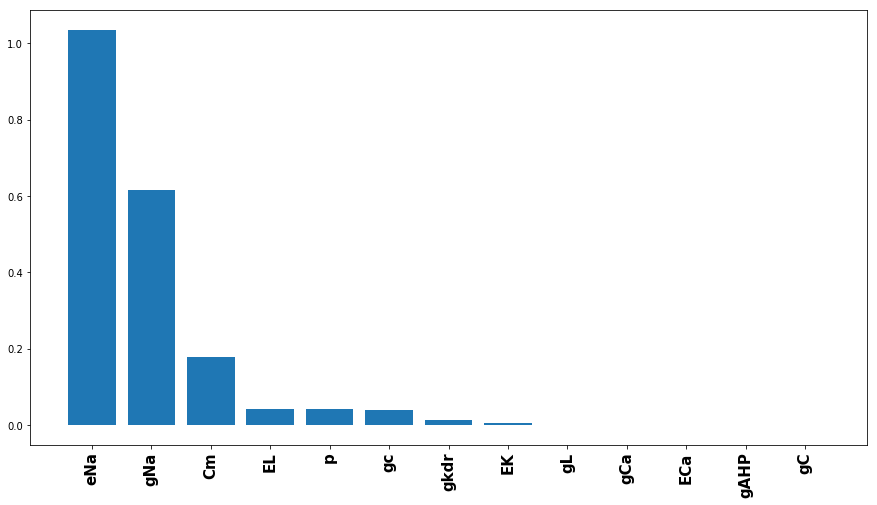

In [0]:
plt.figure(figsize=(15,8))
foonames = [n for _,n in sorted(zip(m[:,1],names))]
foom = sorted(m[:,1])
foonames.reverse()
foom.reverse()
plt.bar(foonames,foom)
plt.xticks(rotation='vertical');
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.savefig("drive/My Drive/Figures/R2plots/First_ap_amp_importance")

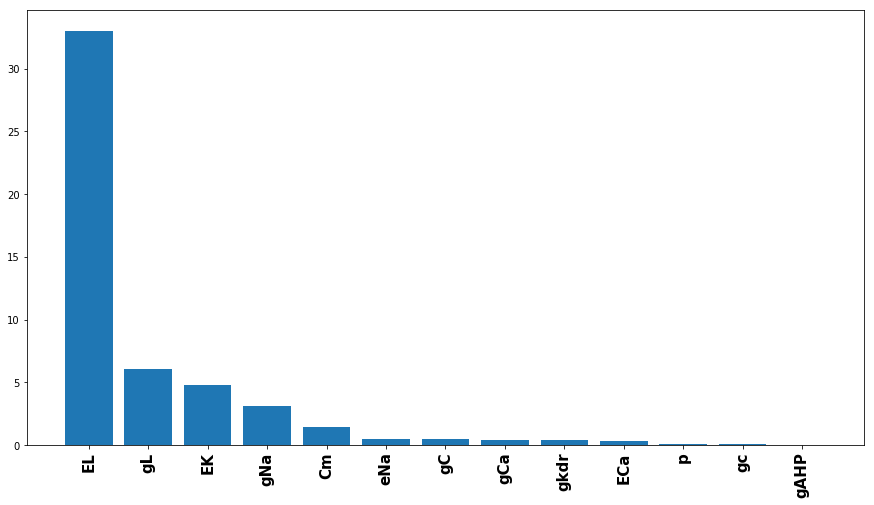

In [0]:
plt.figure(figsize=(15,8))
foonames = [n for _,n in sorted(zip(m[:,2],names))]
foom = sorted(m[:,2])
foonames.reverse()
foom.reverse()
plt.bar(foonames,foom)
plt.xticks(rotation='vertical');
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(15)
    tick.label1.set_fontweight('bold')
plt.savefig("drive/My Drive/Figures/R2plots/First_ap_width_importance")